In [222]:
import networkx as nx
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib import Dataset
from networkx import Graph as NXGraph
import statistics
import collections
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON
from math import factorial
from scipy.linalg import expm
from copy import copy
from scipy.sparse.linalg import eigs

## KG exploration

In [223]:
dataset = Dataset()
dataset.parse("resources/linked-jazz.trig", format="trig")

# take the relationship graph
lj = next(g for g in dataset.graphs() if "relationships" in str(g))
lj_G = rdflib_to_networkx_digraph(lj)

List predicates in the KG

Build the weighted graph

In [224]:
WEIGHTS_MAP = {
    rdflib.term.URIRef('http://linkedjazz.org/ontology/inBandTogether'): 0.8,
    rdflib.term.URIRef('http://linkedjazz.org/ontology/playedTogether'): 0.8,
    rdflib.term.URIRef('http://linkedjazz.org/ontology/touredWith'): 0.9,
    rdflib.term.URIRef('http://purl.org/ontology/mo/collaborated_with'): 0.8,
    rdflib.term.URIRef('http://purl.org/vocab/relationship/acquaintanceOf'): 0.6,
    rdflib.term.URIRef('http://purl.org/vocab/relationship/friendOf'): 0.7,
    rdflib.term.URIRef('http://purl.org/vocab/relationship/hasMet'): 0.2,
    rdflib.term.URIRef('http://purl.org/vocab/relationship/knowsOf'): 0.1,
    rdflib.term.URIRef('http://purl.org/vocab/relationship/mentorOf'): 0.9
}

for i, j in lj_G.edges:
    lj_G[i][j]['weight'] = 0
    for s, p, o in lj_G[i][j]['triples']:
        lj_G[i][j]['weight'] += WEIGHTS_MAP.get(p, 0)

Compute the centrality due to the eigenvectors

In [225]:
ec = nx.eigenvector_centrality(lj_G, weight="weight")

Print the top 10 most influential artists. The label is queried directly from the LinkedJazz KG through a SPARQL query.

In [226]:
def get_dbpedia_label(iri):
  sparql = SPARQLWrapper("https://dbpedia.org/sparql")
  sparql.setReturnFormat(JSON)
  sparql.setQuery("""
  SELECT ?label
  WHERE {
    <%s> rdfs:label ?label .
    FILTER(LANGMATCHES(LANG(?label), \"en\"))
  }
  """ % iri)
  
  try:
    ret = sparql.queryAndConvert()
    label = ret["results"]["bindings"][0]["label"]["value"]
  except:
    label = iri
  return label

for k in sorted(ec, key=ec.get, reverse=True)[:10]:
    label = get_dbpedia_label(str(k))
    print(f"{ec[k]} - {label}")

0.37577864573377373 - Sonny Payne
0.3623081289539205 - Eddie "Lockjaw" Davis
0.3065684168072057 - Eva Jessye
0.2786985607338483 - Bill Hughes (musician)
0.2656548289783715 - Louis Armstrong
0.2605886802410346 - Count Basie
0.25519900471608215 - Miles Davis
0.18766970746297487 - Eubie Blake
0.16814097077664972 - Cat Anderson
0.136681431450689 - Dizzy Gillespie


## Adjacency matrix experiments

In [227]:
def truncated_graph_power_exp(graph: nx.Graph, degree: int) -> np.array:
  """
  Compute the trucated matrix power exponential using Taylor series expansion.

  Args:
      graph (nx.Graph): Input NetworkX grpah.
      degree (int): Tatlor degree of the polynomial

  Returns:
      np.array: Adjacency matrix
  """
  adj = nx.to_numpy_array(graph)
  powadj = adj
  res = adj
  for i in range(2, degree + 1):
      powadj = np.matmul(powadj, adj)
      coeff = 1 / factorial(i)
      res = res + (coeff * powadj)
  return res

In [228]:
#lj_G_exp = truncated_graph_power_exp(lj_G, 8)
lj_G_exp = expm(nx.to_numpy_array(lj_G))

How much did Miles Davis influence Herbie Hancock? What about Count Basie?

Generally, the influence of Miles Davis should be much higher, since Hancock mention him as one of his main inspirations.

In [229]:
miles_davis_idx = list(lj_G.nodes()).index(rdflib.URIRef("http://dbpedia.org/resource/Miles_Davis"))
count_basie_idx = list(lj_G.nodes()).index(rdflib.URIRef("http://dbpedia.org/resource/Count_Basie"))
herbie_hancock_idx = list(lj_G.nodes()).index(rdflib.URIRef("http://dbpedia.org/resource/Herbie_Hancock"))

In [230]:
cp_row = lj_G_exp[herbie_hancock_idx, :]
cp_column = lj_G_exp[:,herbie_hancock_idx]
#print(f"Miles Davis influence in Herbie Hancock: {cp_row[miles_davis_idx]}")
print(f"Miles Davis influence in Herbie Hancock: {cp_column[miles_davis_idx]}")

Miles Davis influence in Herbie Hancock: 0.0


In [231]:
#print(f"Count Basie influence in Herbie Hancock: {cp_row[count_basie_idx]}")
print(f"Count Basie influence in Herbie Hancock: {cp_column[count_basie_idx]}")

Count Basie influence in Herbie Hancock: -4.5283122514043744e-17


Artists to which Herbie Hancock was most influential:

In [232]:
for k in np.argsort(cp_row)[::-1][:20]:
  print(f"{cp_row[k]}: {get_dbpedia_label(list(lj_G.nodes)[k])}")

34.77133415629574: Miles Davis
26.373434381231153: Count Basie
25.555514211132927: Sonny Payne
24.59191687653131: Eddie "Lockjaw" Davis
21.410006065725455: Louis Armstrong
20.80854504937265: Eva Jessye
18.91685913579332: Bill Hughes (musician)
16.070351385383148: Cat Anderson
14.665982613625443: Dizzy Gillespie
13.914349499482768: Ron Carter
12.727545238298575: Eubie Blake
12.666060023292417: Chick Corea
12.448869295314312: Duke Ellington
11.545187838779743: Harry Carney
10.034513550531983: Louie Bellson
9.774690731986185: Oscar Peterson
9.510121767717289: http://dbpedia.org/resource/Alex_Acu%C3%B1a
9.0717232648635: Don Redman
8.96276692581977: Donald Byrd
8.951778742239433: Gil Evans


Most influential artists to Herbie Hancock:

In [233]:
for k in np.argsort(cp_column)[::-1][:20]:
  print(f"{cp_column[k]}: {get_dbpedia_label(list(lj_G.nodes)[k])}")

5.432373965073532: Herbie Hancock
2.811387471969732: Ron Carter
2.059632554933481: Buster Williams
2.0331858407106167: Marian McPartland
1.464220564758246: Dave Brubeck
1.4410811741966136: Charles Davis (saxophonist)
0.699253980228743: Jane Jarvis
0.6974400927904667: Slide Hampton
0.32702435598107354: Delfeayo Marsalis
0.2056553499074212: Abbey Lincoln
0.14199702823241972: Milt Hinton
0.1383394232886428: Jimmy Owens (musician)
0.09382453539603997: Louie Bellson
0.0419851172215363: Oscar Peterson
0.0397822748028104: Annie Ross
0.030350022258218614: http://linkedjazz.org/resource/Stanley_Kay
0.02870879493429242: http://linkedjazz.org/resource/Mona_Hinton
0.019277505765461313: Buddy DeFranco
0.016524214940614085: Toshiko Akiyoshi
0.010966964584295797: Sam Rivers


## Random walk clustering

The idea is to recursively cut the graph into binary partitions $S$ and $S^c$ such that, given the stationary probability vector $\pi$ for a random walk in the graph, the probability with which the random walk in the graph jumps from $S$ to $S^c$ is minimized. In https://dennyzhou.github.io/papers/LLUD.pdf, at page 6 is shown how to obtain such a cut.

In our case, we have first to guarantee the existence of a stationary probability vector. In order to do so, we first make sure that the random walk always performs a random jump when reaching a leaf. Moreover, in order to guarantee aperiodicity we also perform a convex combination of the obtained transition matrix and a random jump in every node (similarly to what is done with PageRank algorithm).

In [260]:
A = nx.to_numpy_array(lj_G)

In [276]:
A

array([[0. , 0.1, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.3, 0. , 0. , ..., 0. , 0. , 0.1],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [277]:
B=copy(A)
N = len(B)

In [278]:
for i in range(N):
    sumi = sum(B[i])
    if sumi ==0 :
         for j in range(N):
            B[i][j] = 1/N
    else:
         for j in range(N):
            B[i][j] = B[i][j]/sumi

In [279]:
B

array([[0.        , 0.00134048, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00051573, 0.00051573, 0.00051573, ..., 0.00051573, 0.00051573,
        0.00051573],
       [0.00675676, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00225225],
       ...,
       [0.00051573, 0.00051573, 0.00051573, ..., 0.00051573, 0.00051573,
        0.00051573],
       [0.00051573, 0.00051573, 0.00051573, ..., 0.00051573, 0.00051573,
        0.00051573],
       [0.00051573, 0.00051573, 0.00051573, ..., 0.00051573, 0.00051573,
        0.00051573]])

In [280]:
jump = np.full((N,N),1/N)
B = 0.99*B + 0.01 * jump

In [281]:
sum(B[0])

1.0000000000000258

In [282]:
bigeig = eigs(B.T , k = 1, which = 'LM')[1][:,0]

In [283]:
piprova = bigeig/sum(bigeig)

In [284]:
piprova

array([0.00060317+0.j, 0.0005009 +0.j, 0.00050022+0.j, ...,
       0.00050193+0.j, 0.00050186+0.j, 0.00050117+0.j])

In [285]:
for i in range(len(piprova)):
    piprova[i] = np.sqrt(piprova[i])

In [286]:
piprova

array([0.02455945+0.j, 0.02238089+0.j, 0.02236553+0.j, ...,
       0.02240383+0.j, 0.0224022 +0.j, 0.02238693+0.j])

In [289]:
piprovainv = copy(piprova)

In [290]:
for i in range(len(piprovainv)):
    piprovainv[i] = 1/piprovainv[i]

In [293]:
piprovainv = np.diag(piprovainv)

In [297]:
piprova = np.diag(piprova)

In [298]:
bigtheta = np.matmul(piprova, np.matmul(B,piprovainv)) + np.matmul(piprovainv, np.matmul(B.T,piprova))/2

In [299]:
bigtheta

array([[0.00011604+0.j, 0.0015702 +0.j, 0.00273527+0.j, ...,
        0.00032003+0.j, 0.00032002+0.j, 0.00031992+0.j],
       [0.00113759+0.j, 0.00077359+0.j, 0.00055474+0.j, ...,
        0.00077333+0.j, 0.00077335+0.j, 0.00077353+0.j],
       [0.00534312+0.j, 0.00033535+0.j, 0.00011604+0.j, ...,
        0.00033553+0.j, 0.00033552+0.j, 0.00224798+0.j],
       ...,
       [0.00051286+0.j, 0.00077386+0.j, 0.00055523+0.j, ...,
        0.00077359+0.j, 0.00077361+0.j, 0.00077379+0.j],
       [0.00051283+0.j, 0.00077384+0.j, 0.00055519+0.j, ...,
        0.00077358+0.j, 0.00077359+0.j, 0.00077377+0.j],
       [0.00051254+0.j, 0.00077366+0.j, 0.00151116+0.j, ...,
        0.0007734 +0.j, 0.00077342+0.j, 0.00077359+0.j]])

In [304]:
eigtheta = eigs(bigtheta , k = 2, which = 'LM')[1][:,1]

In [305]:
eigtheta

array([-0.01425534-0.01999879j, -0.01299082-0.01822479j,
       -0.0129819 -0.01821229j, ..., -0.01300413-0.01824347j,
       -0.01300319-0.01824215j, -0.01299432-0.01822971j])

In [295]:
def ncut(matrix, alpha = 0.99):
    N = len(matrix)
    workingmatrix = copy(matrix)
    #We normalize each row in the adjacency matrix in such a way that each row sums to 1.
    #If the corresponding node is a leaf (each entry is 0), we implement a random jump from there.
    
    for i in range(N):
        sumi = sum(workingmatrix[i])
        if sumi==0:
            for j in range(N):
                workingmatrix[i][j] = 1/N
        else:
            for j in range(N):
                workingmatrix[i][j] = i[j]/sumi
    
    #Now we replace this transition matrix with a convex combination of itself and a random jump:
    
    rjump = np.full((N,N), 1/N)
    workingmatrix = (alpha*workingmatrix) + (1-alpha)*rjump
    
    #Now we are able to compute the stationary probability vector:
    tmatrix = copy(workingmatrix)
    tmatrix = tmatrix.transpose()
    bigeig = eigs(tmatrix , k = 1, which = 'LM')[1][:,0] #it SHOULD return the eigenvector associated to the largest eigvalue (1)
    pi = bigeig/sum(bigeig)
    for i in range(len(pi)):
        pi[i] = np.sqrt(pi[i])
    piinv = copy(pi)
    for i in range(len(pi)):
        piinv[i] = 1/piinv[i]
    pi = np.diag(pi)
    piinv = np.diag(pi)
    
    bigtheta = np.matmul(pi, np.matmul(workingmatrix,piinv)) + np.matmul(piinv, np.matmul(workingmatrix.T,pi))/2
    
    



## A vector implementation

The idea is to use an `Embedding` layer, which assigns a tensor to an index, to represent the weights of the relations.

If we have $R$ relations, then the input to the network will be the adjacency matrix for each relation. 
With $N$ the number of nodes, the input to the network is a matrix of the form $x^{N \times N \times R}$.

We can then leverage NN models to approximate the weights.

In [96]:
from typing import List
import torch
from torch import nn
import torch.nn.functional as F
from collections import defaultdict

INFLUENCED_BY_PRED = rdflib.URIRef("http://purl.org/vocab/relationship/influencedBy")

class SumIRWE(nn.Module):
  def __init__(self, graph: rdflib.Graph, target_pred: rdflib.URIRef, comunicability_degree: float = 8, device: str = "cuda:0"):
    super().__init__()
    self.device = device
    self.c_degree = comunicability_degree

    self.graph = graph
    self.relations = list(set(self.graph.predicates()) - { target_pred })
    self.nx_graph = rdflib_to_networkx_digraph(self.graph)

    # build the input graph by building several different directed graphs that only contains nodes connected by a specific predicate
    self.input = None
    for rel in self.relations:
      sub_g = nx.DiGraph()
      sub_g.add_nodes_from(self.nx_graph.nodes)
      sub_g.add_edges_from(self.graph.subject_objects(rel))

      # 1 x N x N
      sub_g_adj = torch.tensor(nx.to_numpy_array(sub_g)).unsqueeze(0)

      # |R| x N x N
      self.input = sub_g_adj if self.input is None else torch.cat([self.input, sub_g_adj])
    self.input = self.input.to(self.device)

    # build the target graph
    self.target_pred = target_pred
    target_g = nx.DiGraph()
    target_g.add_nodes_from(self.nx_graph.nodes)
    target_g.add_edges_from(self.graph.subject_objects(target_pred))
    self.target = torch.tensor(nx.to_numpy_array(target_g))
    self.target = self.target.to(self.device)

    # NN definition
    self.relation_embedding = nn.Embedding(len(self.relations), 1)
    self.linear = nn.Linear(self.target.shape[0], self.target.shape[0])
    
    self.double()

  @staticmethod
  def compute_communication_matrix(input_adj: torch.tensor, power: int) -> torch.tensor:
    initial_graph = input_adj
    graph_power = input_adj
    for i in range(2, power + 1):
      graph_power = torch.mm(graph_power, initial_graph)
      coeff = torch.tensor(1 / factorial(i))
      input_adj = input_adj + (coeff * graph_power)
    
    return input_adj

  def forward(self):
    # prepare a weight for each relation
    relations_idxs = torch.arange(len(self.relations)).to(self.device)
    
    # compute weight of each relation
    relation_weight = self.relation_embedding(relations_idxs)

    # weight input by casting the weights to |R| x 1 x 1
    w_input = self.input * relation_weight.reshape(-1, 1, 1)

    # combine weights (using sum)
    w_input = w_input.sum(dim=0)

    # compute comunicability up to X degree
    w_input = SumIRWE.compute_communication_matrix(w_input, self.c_degree)
    w_input = self.linear(w_input)
    
    # compute cross entropy loss: the problem is a classification problem
    loss = F.cross_entropy(w_input, self.target)
    return loss, w_input

  def evaluate(self, k: int):
    influenced = defaultdict(list)
    for s, o in self.graph.subject_objects(self.target_pred):
      influenced[s].append(o)

    _, adj = self.forward()
    precisions = []
    recalls = []
    f1s = []
    for artist, influences in influenced.items():
      artist_idx = list(self.nx_graph.nodes()).index(artist)
      influenced_row = adj[artist_idx, :]
  
      top_idxs = torch.flip(torch.argsort(influenced_row), (0,))
  
      relevant = set(influences)
      retrieved = set([list(self.nx_graph.nodes())[i] for i in torch.flip(torch.argsort(influenced_row), (0,))[:k]])

      precisions.append(len(set(relevant).intersection(retrieved)) / len(retrieved))
      recalls.append(len(set(relevant).intersection(retrieved)) / len(relevant))
      f1s.append((2 * precisions[-1] * recalls[-1]) / (precisions[-1] + recalls[-1] + 1e-50))

    
    return { 
      f"P@{k}": np.mean(precisions), 
      f"R@{k}": np.mean(recalls), 
      f"F1@{k}": np.mean(f1s) 
    }

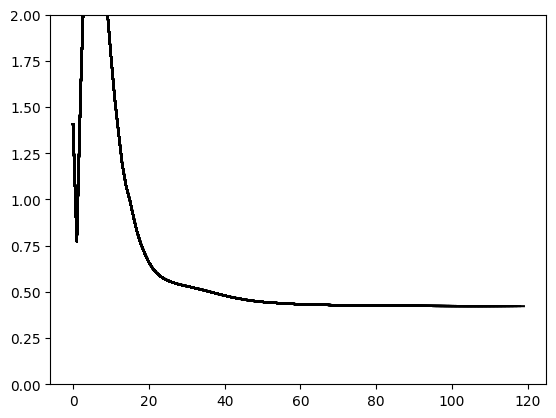

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

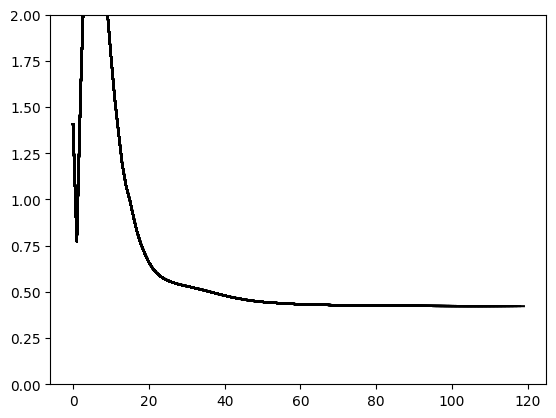

In [98]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython import display

fig, ax = plt.subplots()
dh = display.display(fig, display_id=True)

model = SumIRWE(lj, INFLUENCED_BY_PRED, comunicability_degree=8)
model.to("cuda:0")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

losses = []
metrics = []
for step in (pbar := tqdm(list(range(1000)))):
  loss, _ = model()
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  losses.append(loss.item())

  if (step % 10) == 0:
    metrics.append({n: v for k in [1, 5, 10, 20, 25] for n, v in model.evaluate(k).items()})
    pbar.set_postfix_str(f" P: {metrics[-1]['P@10']:1.2f} R: {metrics[-1]['R@10']:1.2f}")
  
  ax.plot(range(len(losses)), losses, c="k")
  dh.update(fig)

  pbar.set_description(f"Loss: {losses[-1]:1.8f}")


In [100]:
metrics[-1]

{'P@1': 1.0,
 'R@1': 0.2970070651814073,
 'F1@1': 0.41130829640445027,
 'P@5': 0.75,
 'R@5': 0.7975353259070365,
 'F1@5': 0.6788257167923457,
 'P@10': 0.5307692307692308,
 'R@10': 0.9308459875894086,
 'F1@10': 0.5902213553175227,
 'P@20': 0.32211538461538464,
 'R@20': 0.9859712047212047,
 'F1@20': 0.425747855036117,
 'P@25': 0.26692307692307693,
 'R@25': 0.9943687678062678,
 'F1@25': 0.3715620830333623}

In [113]:
for r, w in zip(model.relations, model.relation_embedding.weight.reshape(-1)):
  print(f"{w.item():1.3f} - {r}")

0.834 - http://purl.org/vocab/relationship/friendOf
0.088 - http://purl.org/ontology/mo/collaborated_with
0.250 - http://purl.org/vocab/relationship/knowsOf
-0.663 - http://linkedjazz.org/ontology/inBandTogether
-1.045 - http://purl.org/vocab/relationship/mentorOf
1.348 - http://linkedjazz.org/ontology/bandmember
-0.403 - http://linkedjazz.org/ontology/playedTogether
-0.503 - http://purl.org/vocab/relationship/acquaintanceOf
-0.023 - http://linkedjazz.org/ontology/touredWith
0.184 - http://purl.org/vocab/relationship/hasMet
0.034 - http://linkedjazz.org/ontology/bandLeaderOf
